In [16]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import time    

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import emd

import torch

from ml.neural_network import MeanAbsoluteError, NeuralNetFunc

from external_drift import SingleMultivariateNeuralODE, ScenarioParams
from plot import ImperialColors

In [17]:
df_raw = pd.read_csv("day_ahead_market_20211005.csv")
df_raw["spain"] = df_raw["spain"].round(decimals=2)

In [18]:
long_signal_df = df_raw[(df_raw["year"] == 2021) & (df_raw["month"] <= 6)]
signal_df = long_signal_df[(long_signal_df["month"] <= 4) | ((long_signal_df["month"] == 5) & (long_signal_df["day"] == 1))]
signal_df["date_hour"] = (pd.to_datetime(signal_df["date"]) + pd.to_timedelta(signal_df["hour"] - 1, unit="H"))
ts_df = pd.DataFrame(index=signal_df["date_hour"].values, data=signal_df["spain"].values)

/var/folders/n4/4pcf4gm94bsfkqcmfpznj3nh0000gp/T/ipykernel_51378/1206612232.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signal_df["date_hour"] = (pd.to_datetime(signal_df["date"]) + pd.to_timedelta(signal_df["hour"] - 1, unit="H"))


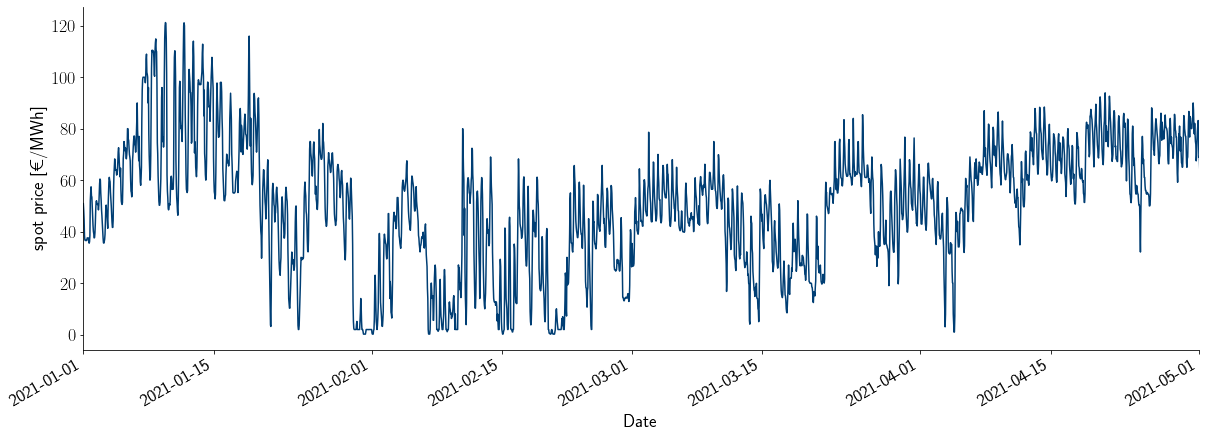

In [19]:
plt.rcParams['text.usetex'] = True

fig, ax = plt.subplots(figsize=(20, 7))

ts_df.plot(ax=ax, ls="-", legend=False, zorder=2, color=ImperialColors.blue.value)

ax.set_xlim(18628, 18748)

ax.set_xlabel("Date", fontsize=18)
ax.set_ylabel(r"spot price [€/MWh]", fontsize=18)
ax.tick_params(axis='both', labelsize=18)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig("figures/emd_conference_price_ts.pdf")
plt.rcParams['text.usetex'] = False

In [20]:
imf = emd.sift.sift(ts_df.iloc[:, 0].values)

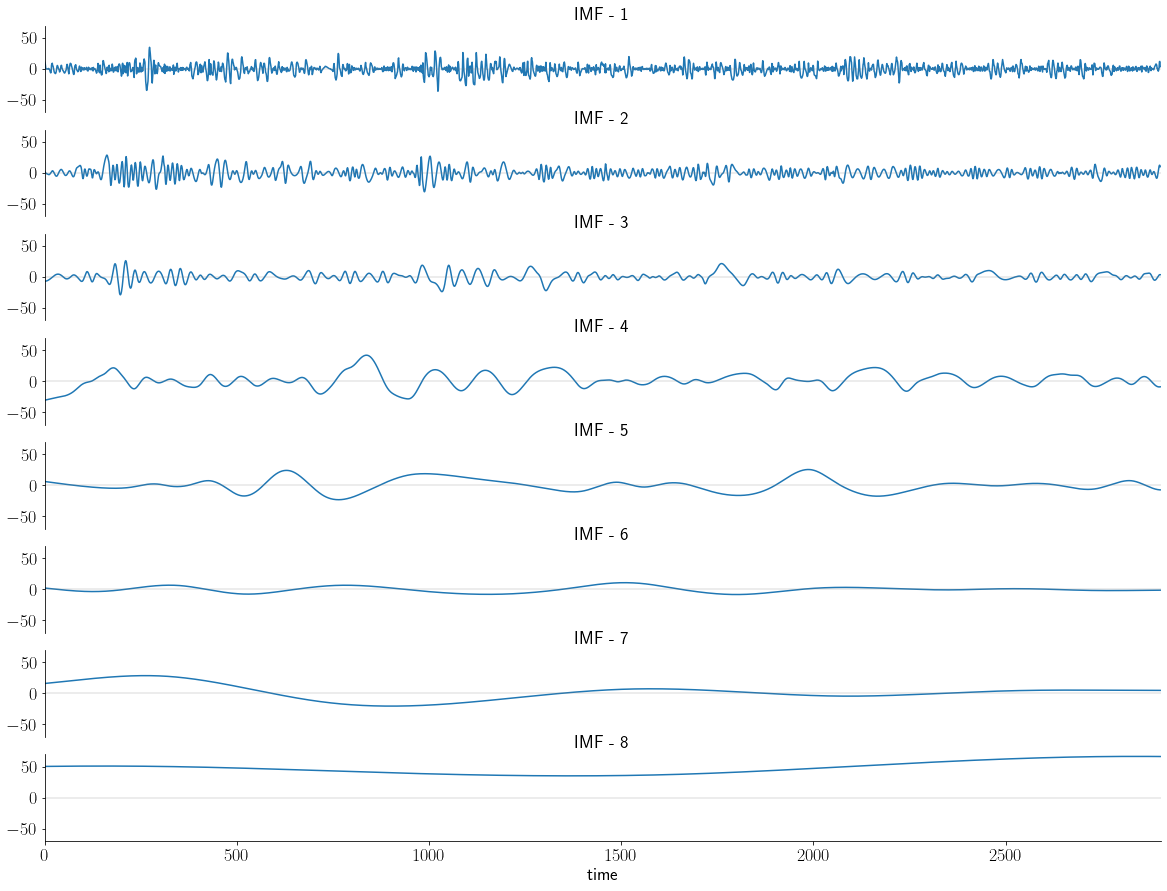

In [21]:
plt.rcParams['text.usetex'] = True
fig, ax = plt.subplots(imf.shape[1], 1, figsize=(20, 15))

for i, axis in enumerate(ax):
    axis.plot(np.arange(0, imf.shape[0]), imf[:, i])
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)
    axis.set_xlim(0, imf.shape[0])
    axis.set_ylim(-70, 70)
    axis.set_title(f"IMF - {i+1}", fontsize=18)
    axis.axhline(y=0, color="grey", alpha=0.2)
    axis.tick_params(axis="both", labelsize=18)
    if i != imf.shape[1] - 1:
        axis.spines["bottom"].set_visible(False)
        axis.set_xticks([])
    else:
        axis.set_xlabel("time", fontsize=18)
        
fig.savefig("figures/imfs.pdf")
plt.rcParams['text.usetex'] = False

#### 24 time series breakdown


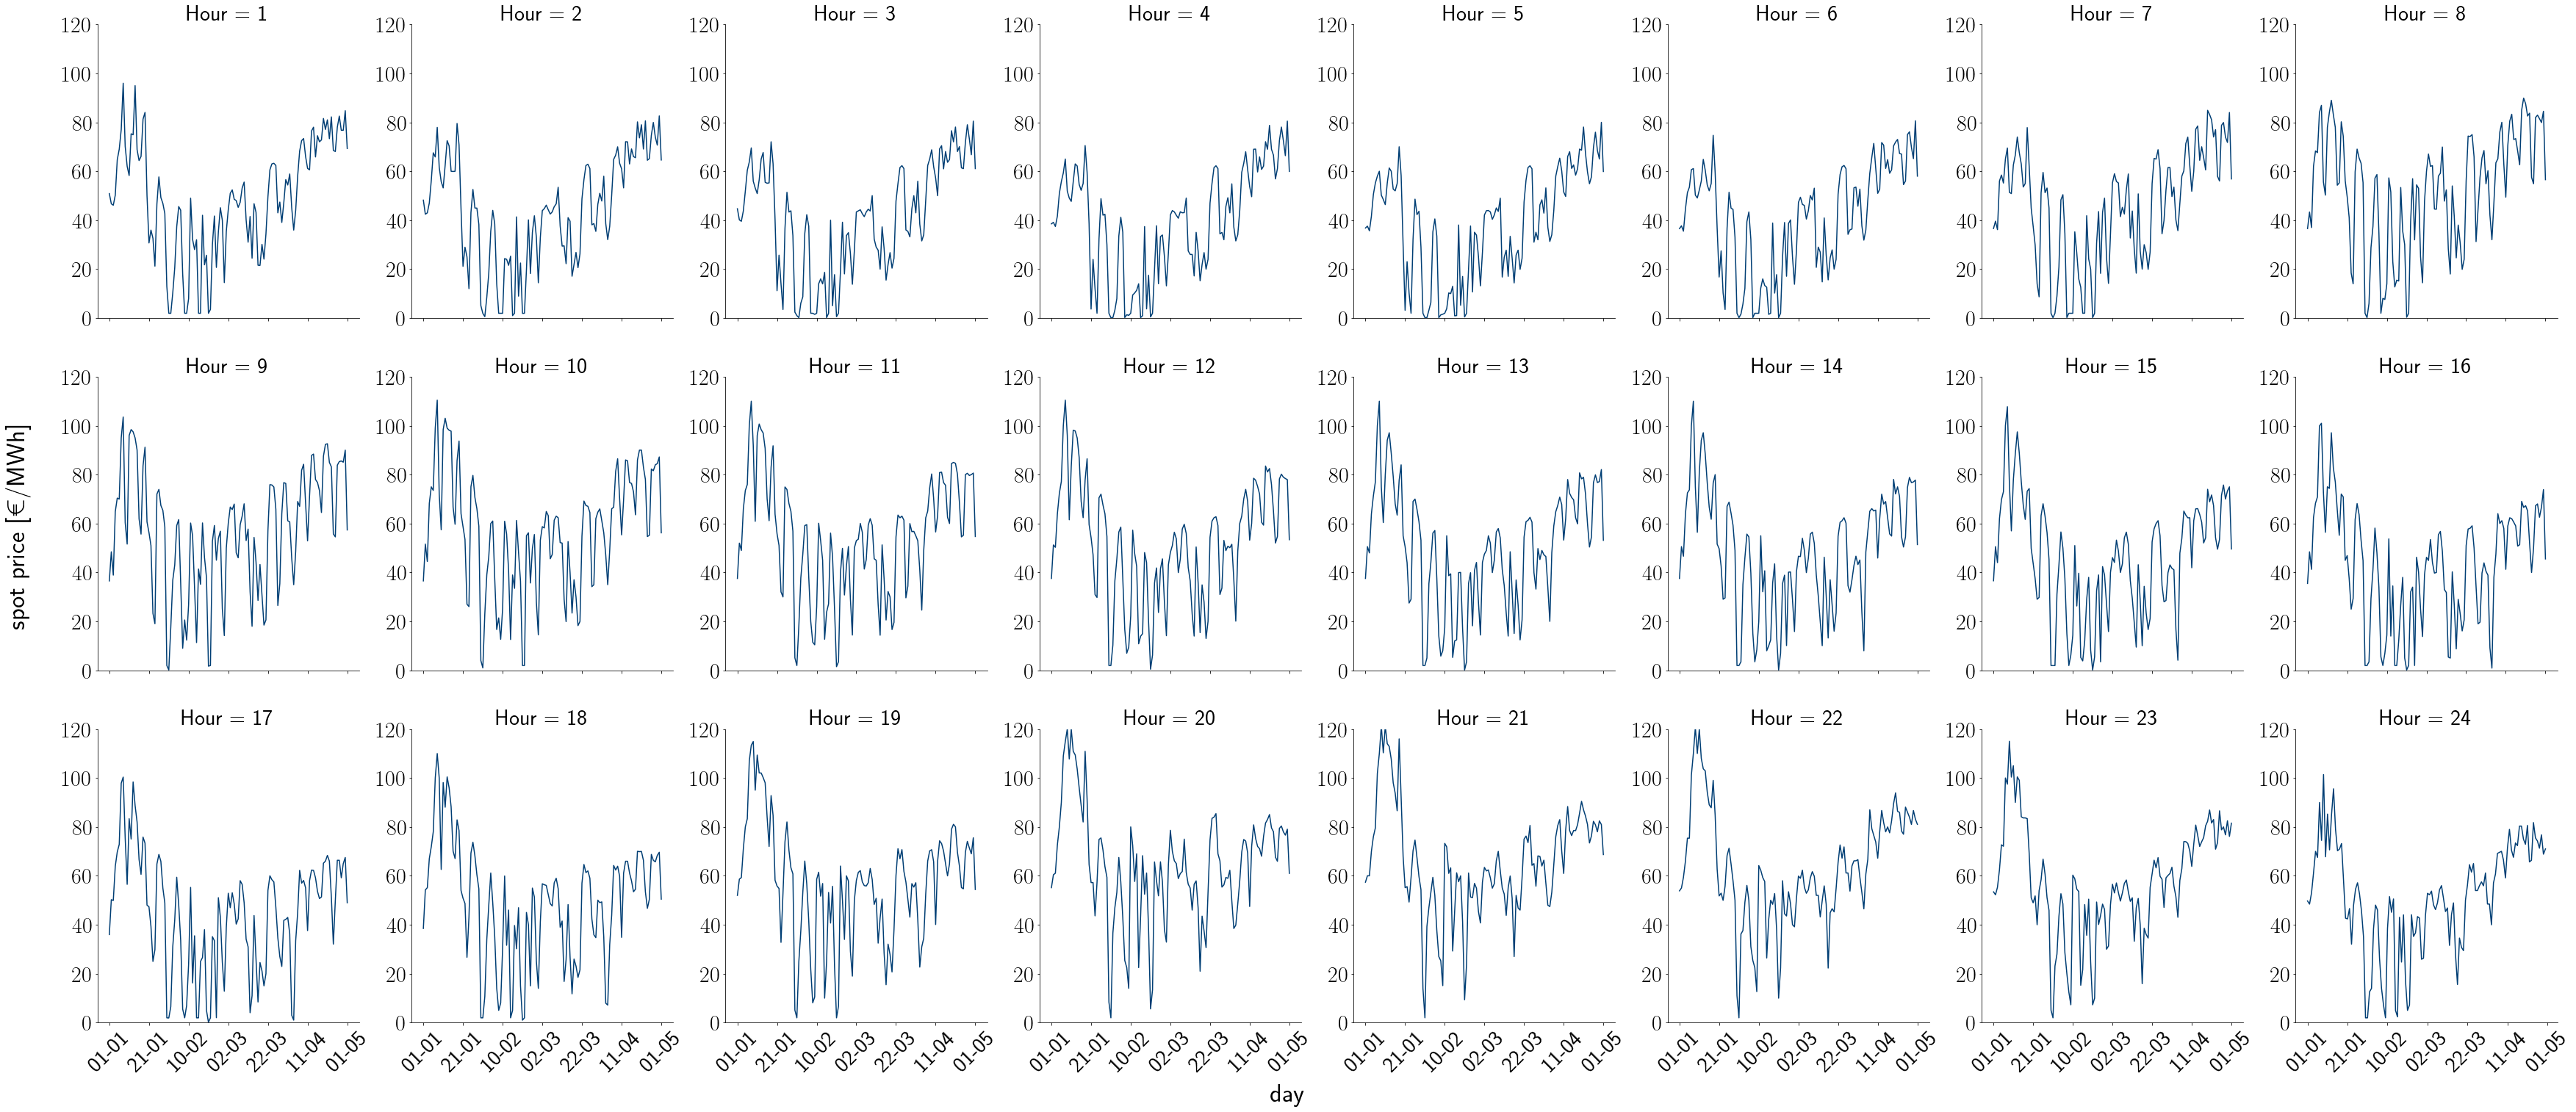

In [48]:
plt.rcParams['text.usetex'] = True
myFmt = mdates.DateFormatter('%d-%m')
fig, axis = plt.subplots(3, 8, figsize=(60, 25))

xnew = np.arange(0, 150) 
for i, ax_list in enumerate(axis):
    for j, ax in enumerate(ax_list):
        h = 1 + i*8+j
        aux_df = signal_df.query(f" hour == {h}")[["date", "spain"]].set_index("date")
        aux_df.plot(ax=ax, color=ImperialColors.blue.value, legend=False)
        ax.set_xlabel("")
        ax.set_title(f"Hour = {h}", fontsize=30)
        ax.set_ylim(0, 120)
        ax.tick_params(axis='both', labelsize=30)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_xticklabels(ax.get_xticks(), rotation = 45)
        ax.xaxis.set_major_formatter(myFmt)
        if h <= 16:
            ax.set_xticklabels([])
        
fig.text(0.5, 0.07, "day", ha="center", va="center", fontdict={"size": 35})
fig.text(0.1, 0.5, "spot price [€/MWh]", ha="center", va="center",
         fontdict={"size": 35}, rotation=90)

#fig.savefig("figures/24_spot_price_ts.pdf")
plt.rcParams['text.usetex'] = False

In [75]:
# Analyse just one hour signal
h_signal_df = signal_df.query("hour == 1")[["date", "spain"]].set_index("date")

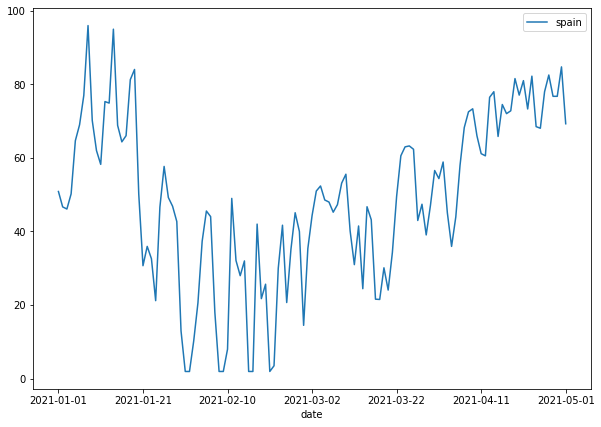

In [76]:
_ = h_signal_df.plot(figsize=(10, 7), label=False)

In [77]:
h_imf = emd.sift.sift(h_signal_df.iloc[:, 0].values)

In [78]:
h_imf.shape

(121, 4)

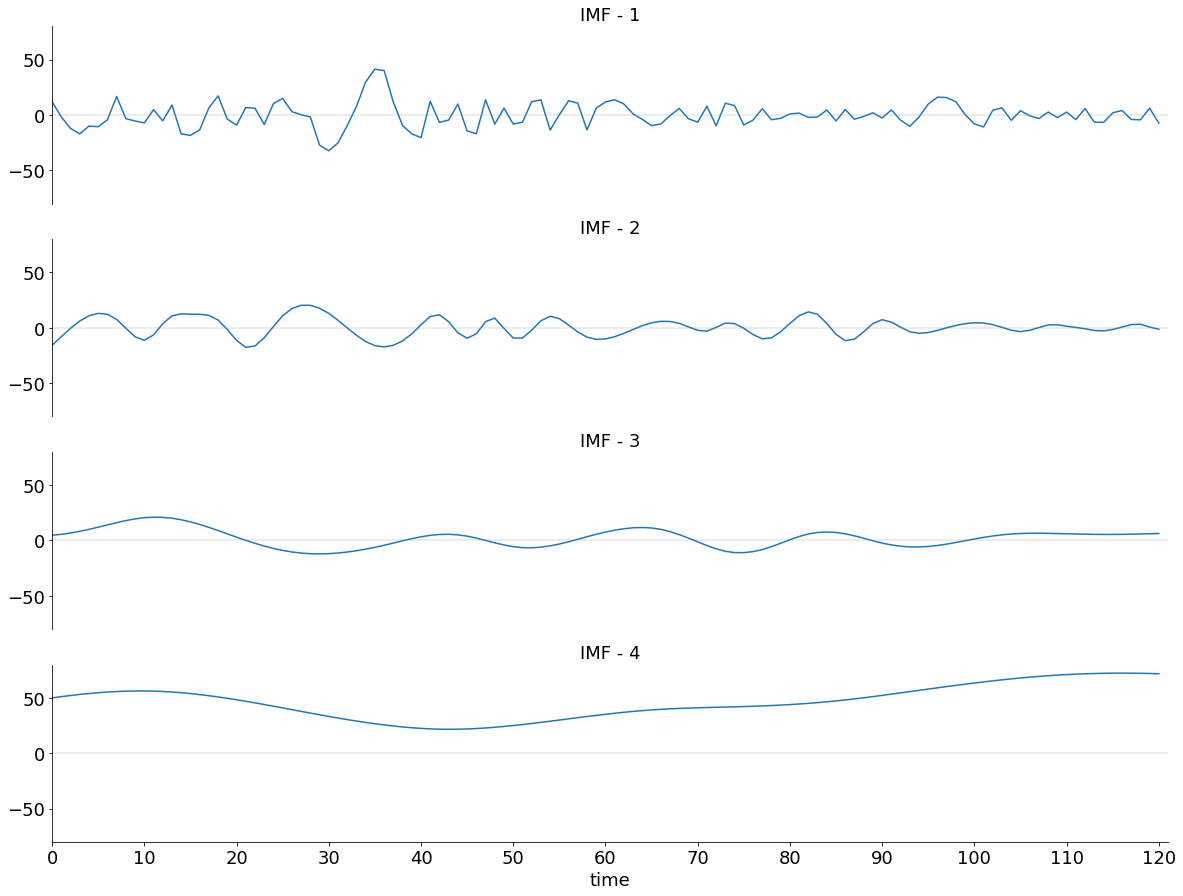

In [79]:
#plt.rcParams['text.usetex'] = True
fig, axis = plt.subplots(h_imf.shape[1], 1, figsize=(20, 15))

for i, ax in enumerate(axis):
    ax.plot(np.arange(0, h_imf.shape[0]), h_imf[:, i])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(0, h_imf.shape[0])
    ax.set_ylim(-80, 80)
    ax.set_title(f"IMF - {i+1}", fontsize=18)
    ax.axhline(y=0, color="grey", alpha=0.2)
    ax.tick_params(axis="both", labelsize=18)
    if i != h_imf.shape[1] - 1:
        ax.spines["bottom"].set_visible(False)
        ax.set_xticks([])
    else:
        ax.set_xlabel("time", fontsize=18)
        ax.set_xticks(ticks=np.arange(0, 121, 10))
        
#fig.savefig("figures/imfs.pdf")
#plt.rcParams['text.usetex'] = False

#### Train neural ODE

In [89]:
def get_training_arrays(dataset, ts, params):
    batch_t = torch.from_numpy(np.arange(ts + 1, dtype=float))
    batch_y = torch.from_numpy(dataset[:ts+1, :].reshape(ts + 1, params.batch_size, 1, params.obs_dim)).float()
    batch_y0 = batch_y[0]
    
    return batch_y0, batch_t, batch_y

In [104]:
def plot_ode(dataset, true_y, pred_test_y, test_size):
    fig, ax = plt.subplots(dataset.shape[1], 1, figsize=(10, 7))

    for i, axis in enumerate(ax):
        axis.scatter(np.arange(0, true_y.shape[0] - test_size), true_y[:-test_size, i], color=ImperialColors.blue.value)
        axis.scatter(np.arange(true_y.shape[0] - test_size, true_y.shape[0]), true_y[-test_size:, i], 
                     color=ImperialColors.seaglass.value)
        axis.plot(np.arange(0, pred_test_y.shape[0]), pred_test_y[:, i], color=ImperialColors.cool_grey.value)
        axis.spines['right'].set_visible(False)
        axis.spines['top'].set_visible(False)
        axis.set_xlim(0, pred_test_y.shape[0])
        #axis.set_ylim(-70, 70)
        axis.axhline(y=0, color=ImperialColors.cool_grey.value, alpha=0.2)
        if i != imf.shape[1] - 1:
            axis.spines["bottom"].set_visible(False)
            axis.set_xticks([])
        else:
            axis.set_xlabel("time")
    plt.show()

Training time step 1 - Iteration: 0000 | Total loss 2.851593 | Time: 0.00 mins


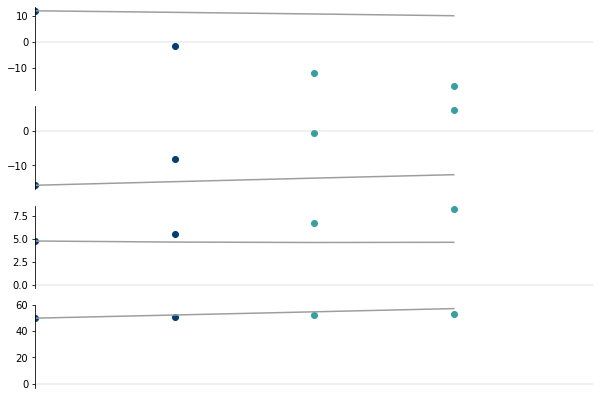

Training time step 1 - Iteration: 0500 | Total loss 0.024333 | Time: 0.08 mins


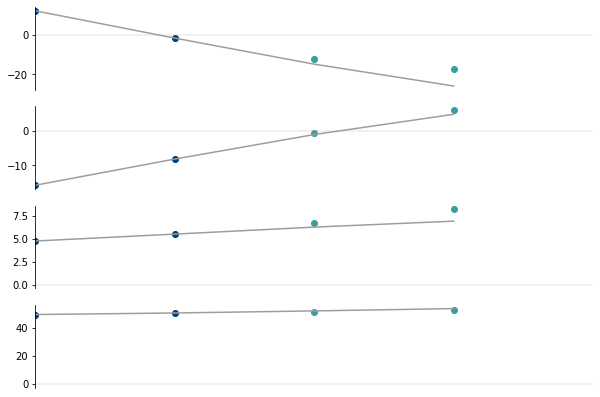

Training time step 1 - Iteration: 1000 | Total loss 0.023844 | Time: 0.16 mins


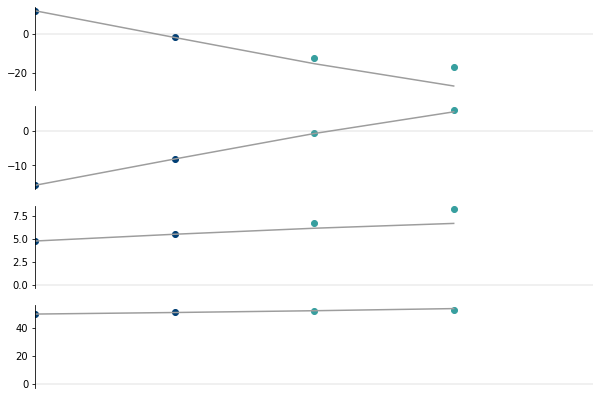

Training time step 1 - Iteration: 1500 | Total loss 0.023612 | Time: 0.24 mins


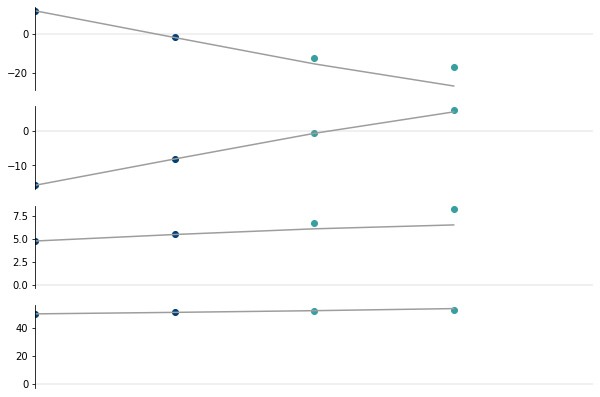

Training time step 1 - Iteration: 2000 | Total loss 0.023614 | Time: 0.32 mins


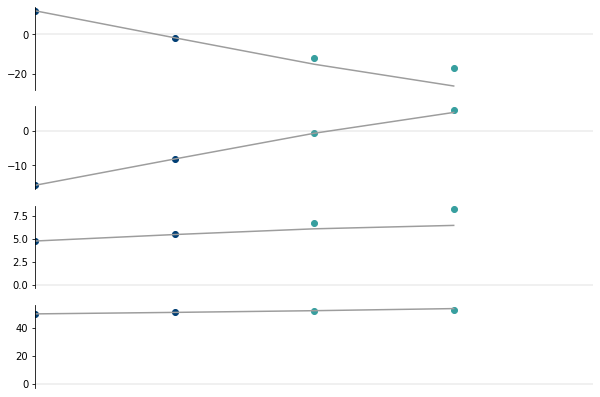

Training time step 2 - Iteration: 0000 | Total loss 0.334098 | Time: 0.32 mins


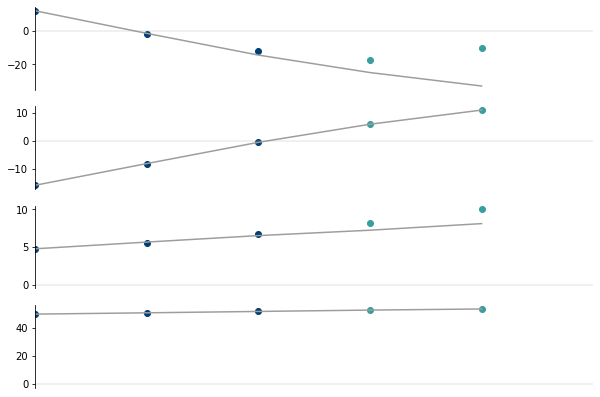

Training time step 2 - Iteration: 0500 | Total loss 0.047639 | Time: 0.49 mins


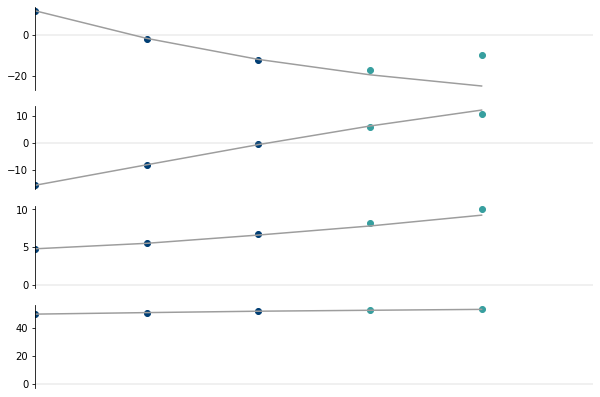

Training time step 2 - Iteration: 1000 | Total loss 0.046388 | Time: 0.65 mins


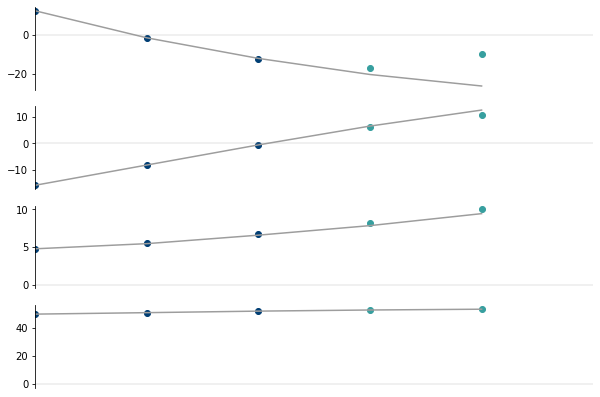

Training time step 2 - Iteration: 1500 | Total loss 0.045347 | Time: 0.84 mins


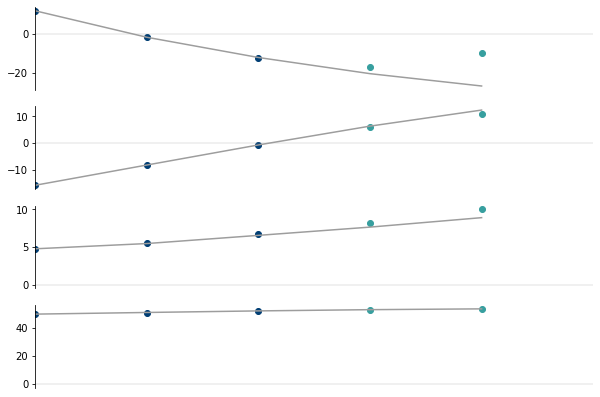

Training time step 2 - Iteration: 2000 | Total loss 0.046574 | Time: 1.04 mins


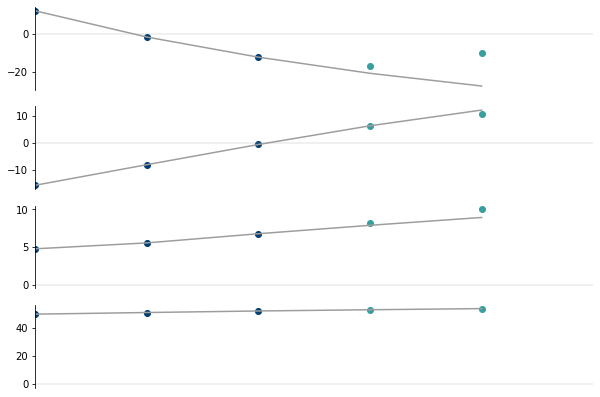

Training time step 3 - Iteration: 0000 | Total loss 0.304148 | Time: 1.04 mins


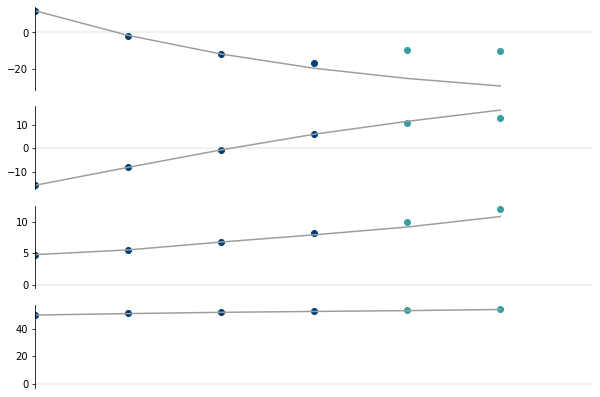

Training time step 3 - Iteration: 0500 | Total loss 0.060785 | Time: 1.30 mins


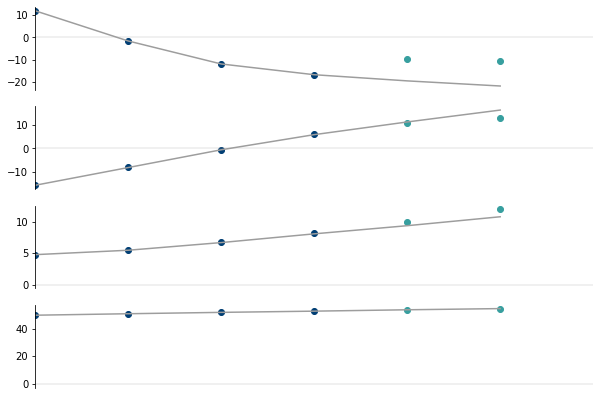

Training time step 3 - Iteration: 1000 | Total loss 0.069110 | Time: 1.57 mins


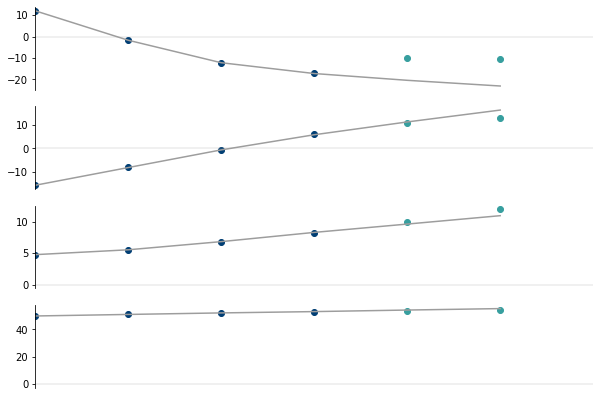

Training time step 3 - Iteration: 1500 | Total loss 0.068374 | Time: 1.84 mins


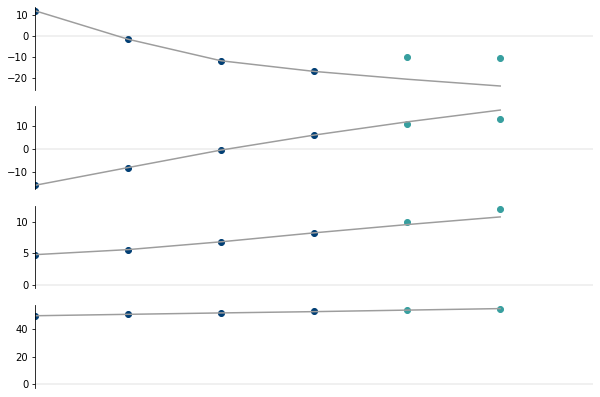

Training time step 3 - Iteration: 2000 | Total loss 0.068189 | Time: 2.11 mins


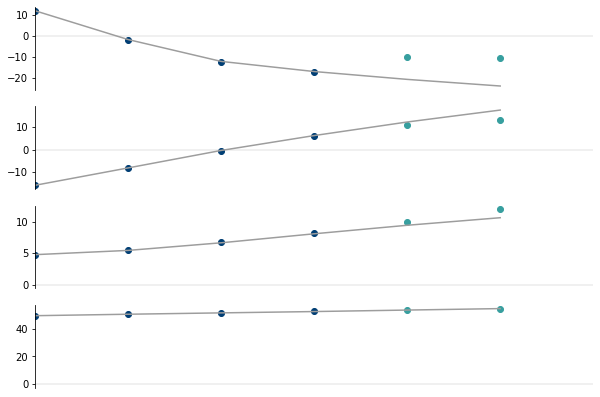

Training time step 4 - Iteration: 0000 | Total loss 0.688506 | Time: 2.12 mins


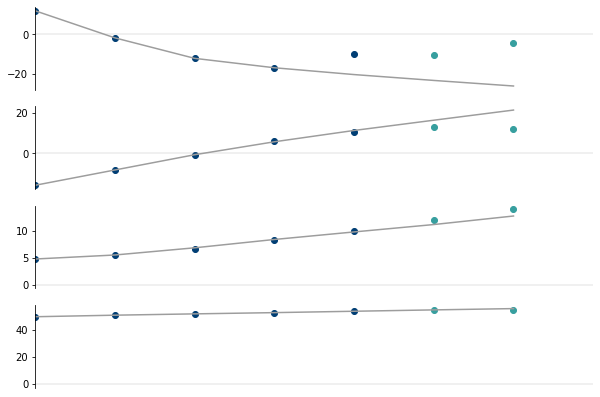

Training time step 4 - Iteration: 0500 | Total loss 0.151711 | Time: 2.44 mins


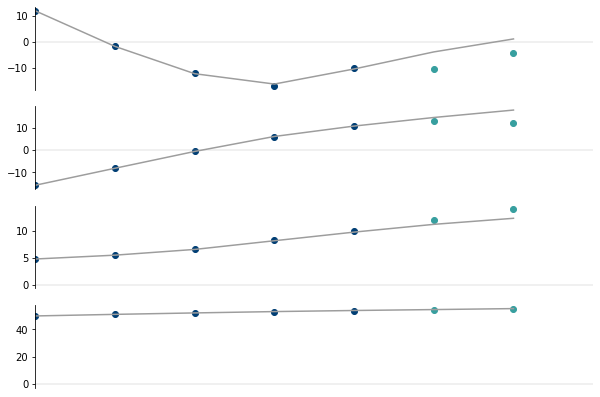

Training time step 4 - Iteration: 1000 | Total loss 0.109036 | Time: 2.78 mins


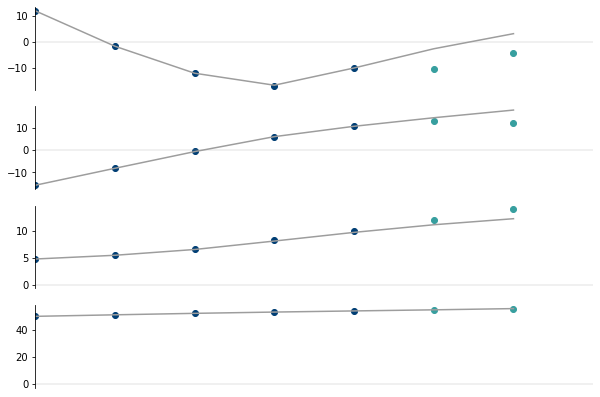

Training time step 4 - Iteration: 1500 | Total loss 0.108369 | Time: 3.12 mins


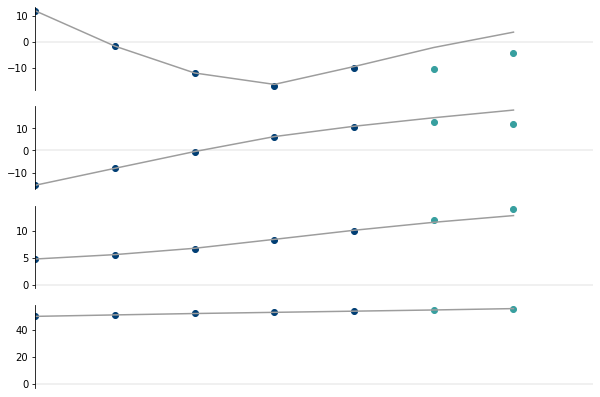

Training time step 4 - Iteration: 2000 | Total loss 0.096605 | Time: 3.45 mins


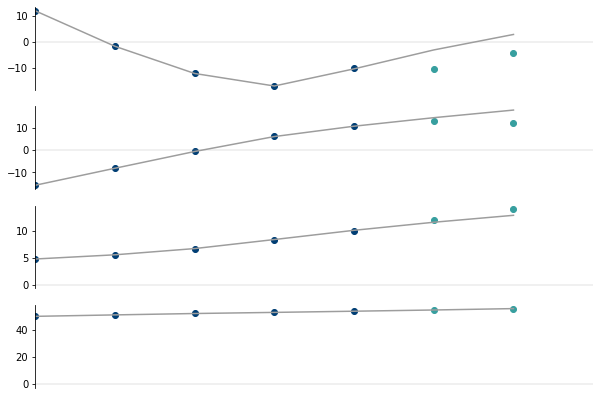

Training time step 5 - Iteration: 0000 | Total loss 0.456013 | Time: 3.46 mins


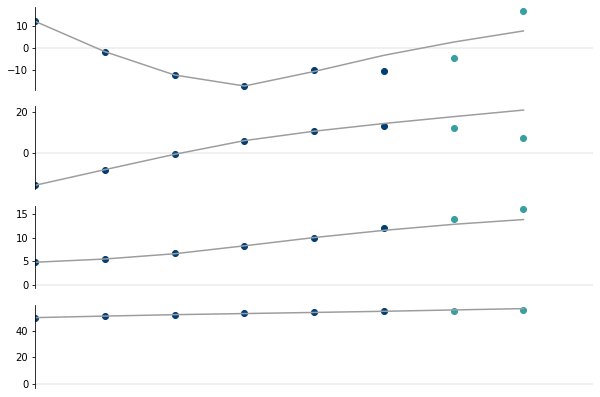

Training time step 5 - Iteration: 0500 | Total loss 0.220419 | Time: 3.85 mins


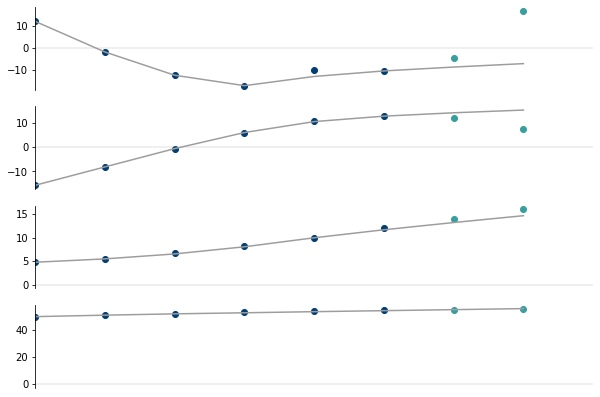

Training time step 5 - Iteration: 1000 | Total loss 0.190173 | Time: 4.25 mins


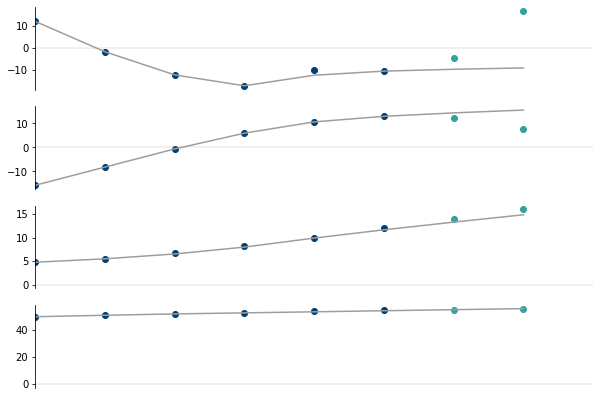

Training time step 5 - Iteration: 1500 | Total loss 0.160485 | Time: 4.67 mins


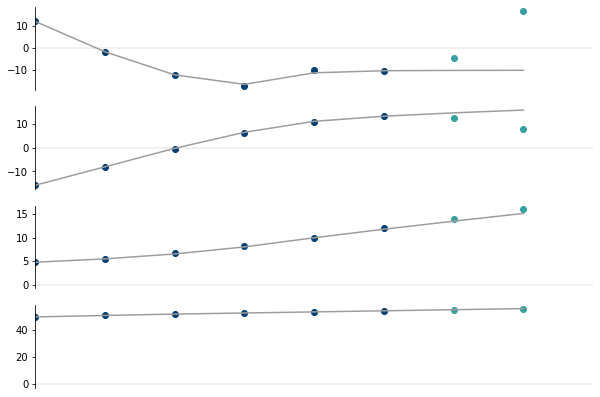

Training time step 5 - Iteration: 2000 | Total loss 0.137175 | Time: 5.12 mins


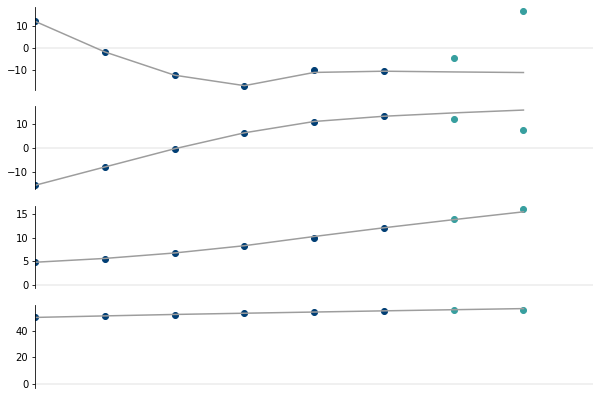

Training time step 6 - Iteration: 0000 | Total loss 0.442271 | Time: 5.13 mins


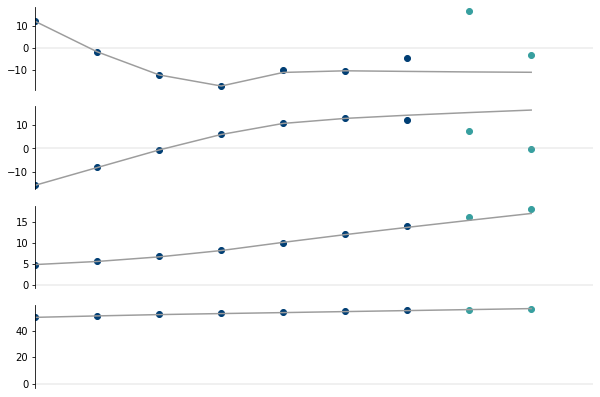

Training time step 6 - Iteration: 0500 | Total loss 0.264958 | Time: 5.61 mins


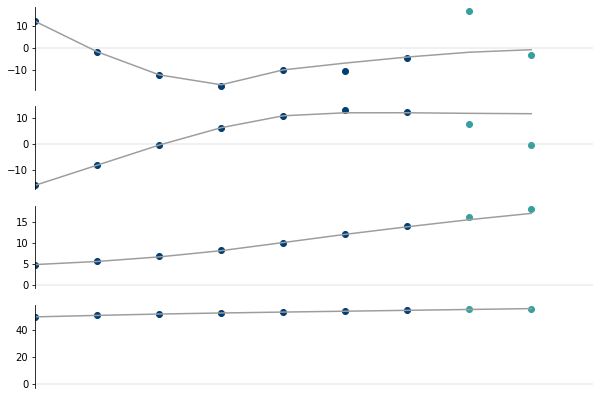

Training time step 6 - Iteration: 1000 | Total loss 0.247960 | Time: 6.13 mins


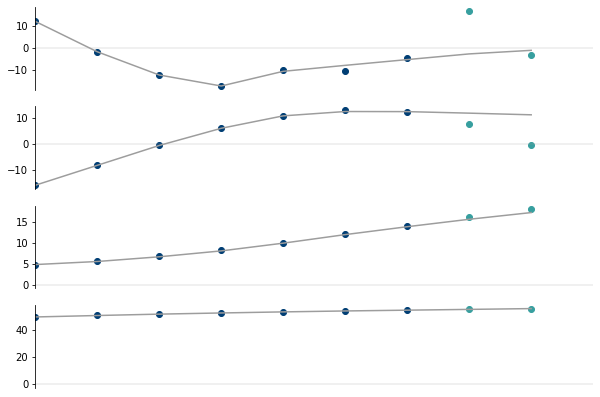

Training time step 6 - Iteration: 1500 | Total loss 0.233215 | Time: 6.65 mins


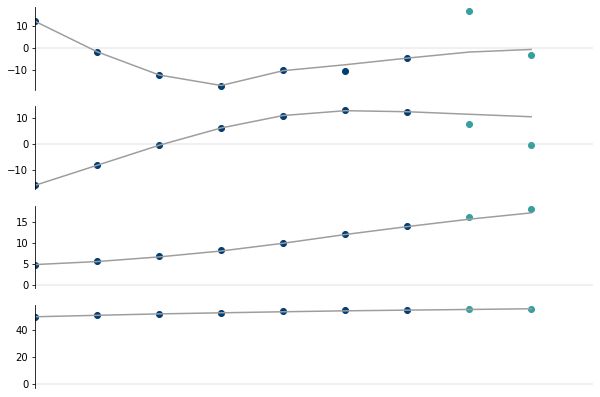

Training time step 6 - Iteration: 2000 | Total loss 0.218472 | Time: 7.20 mins


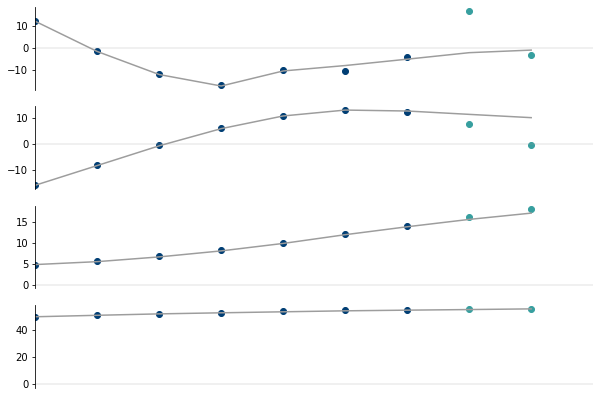

Training time step 7 - Iteration: 0000 | Total loss 0.974627 | Time: 7.20 mins


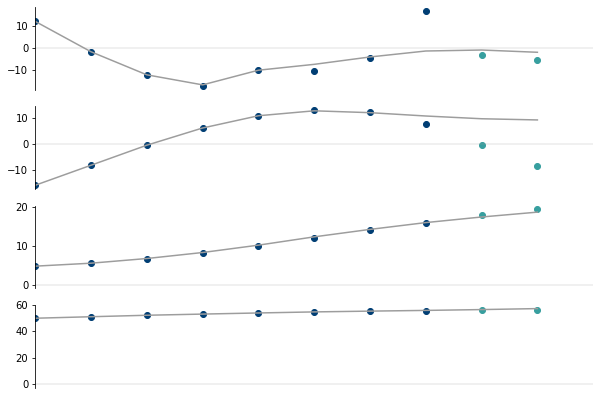

Training time step 7 - Iteration: 0500 | Total loss 0.660986 | Time: 7.83 mins


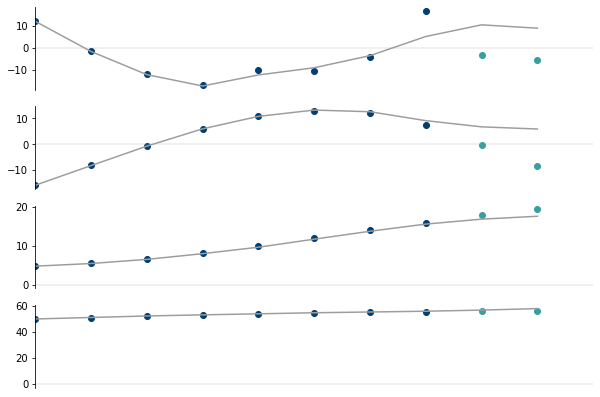

Training time step 7 - Iteration: 1000 | Total loss 0.474175 | Time: 8.51 mins


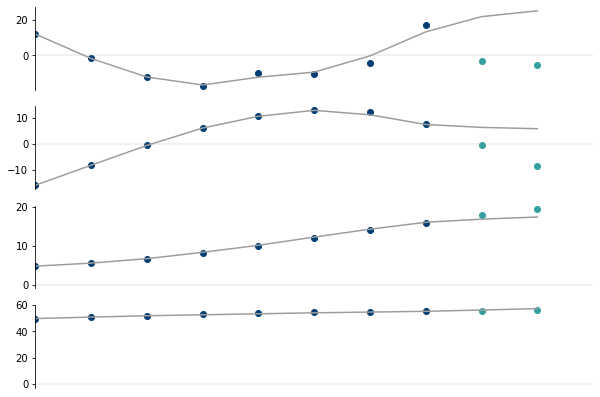

Training time step 7 - Iteration: 1500 | Total loss 0.390559 | Time: 9.26 mins


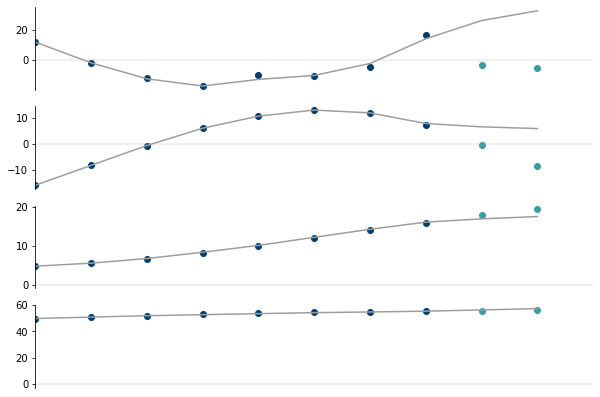

Training time step 7 - Iteration: 2000 | Total loss 0.340471 | Time: 10.04 mins


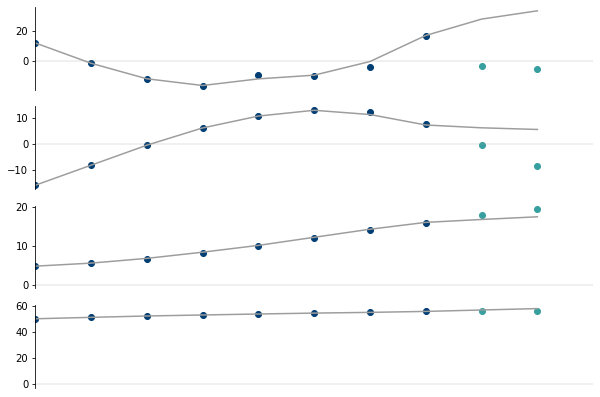

Training time step 8 - Iteration: 0000 | Total loss 1.417231 | Time: 10.04 mins


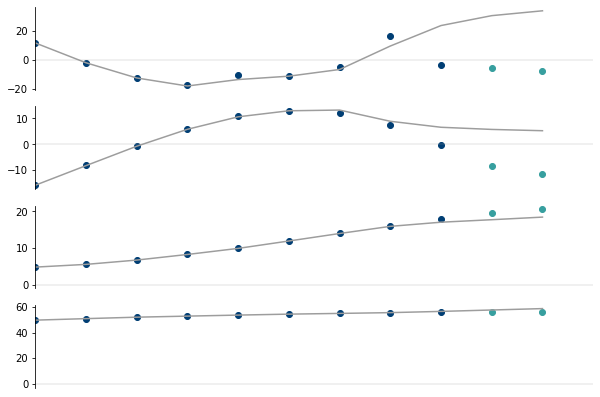

Training time step 8 - Iteration: 0500 | Total loss 0.678615 | Time: 10.97 mins


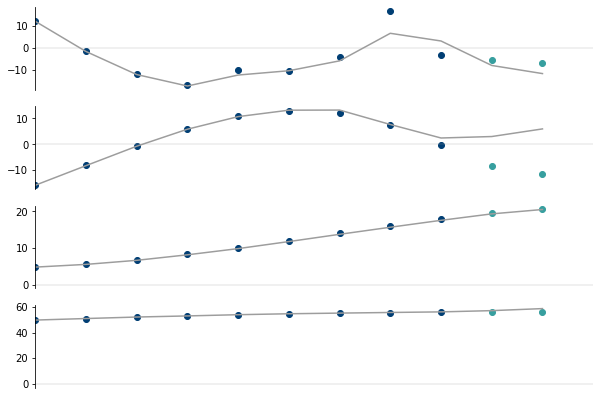

Training time step 8 - Iteration: 1000 | Total loss 0.610386 | Time: 11.93 mins


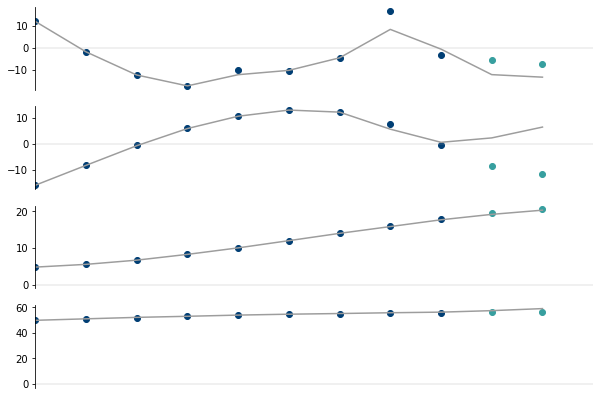

Training time step 8 - Iteration: 1500 | Total loss 0.552378 | Time: 12.94 mins


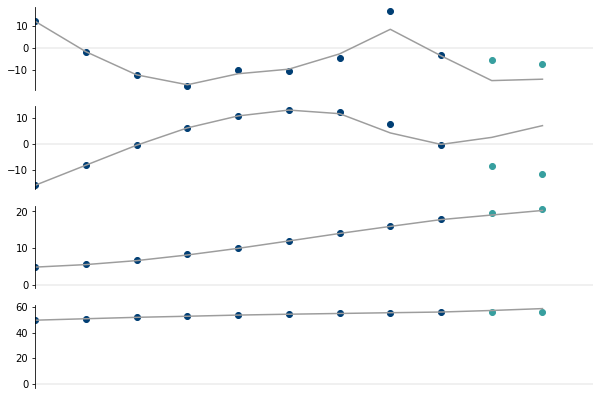

KeyboardInterrupt: 

In [105]:
#hidden_layer_neurons = [24, 96, 180, 256, 512, 512, 512, 180, 96, 24]
hidden_layer_neurons = [96]
#activation_functions = [torch.nn.Tanh()] * 10
activation_functions = [torch.nn.Tanh()]
loss_func = MeanAbsoluteError()

params = ScenarioParams(sim_periods=15, 
                        n_sim=1_000, 
                        delta_t=1, 
                        seed=1_024, 
                        batch_size=1, 
                        obs_dim=h_imf.shape[1],
                        epochs=2_000,
                        lr=1e-3)

device = torch.device("cpu")

init_window_length = 0

func = NeuralNetFunc(obs_dim=h_imf.shape[1],
                     hidden_layer_neurons=hidden_layer_neurons,
                     activation_functions=activation_functions)
node = SingleMultivariateNeuralODE(params=params,
                                   neural_ode_template=func,
                                   optimizer=torch.optim.RMSprop,
                                   loss_func=loss_func,
                                   loss_momentum=0.97)

test_size = 2
start = time.time()
for j in range(1, params.sim_periods - 1):
    training_ts = init_window_length + params.delta_t * j
    
    node.initialize_loss_meter()
    
    batch_y0, batch_t, batch_y = get_training_arrays(dataset=h_imf, ts=training_ts, params=params)
        
    batch_y0 = batch_y0.to(device)
    batch_t = batch_t.to(device)
    batch_y = batch_y.to(device)
    
    for itr in range(0, params.epochs + 1):
        node.train(batch_y0=batch_y0, batch_t=batch_t, batch_y=batch_y)

        end = time.time()
        training_time = (end - start) / 60
        if itr % (params.epochs // 4) == 0:
            print(f"Training time step {j} - Iteration: {itr:04d} | Total loss {node.loss():.6f} | Time: {training_time:.2f} mins")
            
            true_y0, true_t, true_y = get_training_arrays(dataset=h_imf, ts=training_ts+test_size, params=params)

            with torch.no_grad():
                pred_test_y = node.solve_initial_value(batch_y0=true_y0, batch_t=true_t)
                
                true_y = true_y.reshape(true_t.shape[0], h_imf.shape[1])
                pred_test_y = pred_test_y.reshape(true_t.shape[0], h_imf.shape[1])
                plot_ode(dataset=h_imf, true_y=true_y, pred_test_y=pred_test_y, test_size=test_size)